# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

# Homework 1 - Supervised Deep Learning

Chioccarello Stefano

Student ID: 2011656


# Regression task

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import loguniform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [ ]:
torch.manual_seed(2011656)    
np.random.seed(2011656)

## Dataset and Dataloader

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-01-01 10:00:25--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-01-01 10:00:26 (79.7 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-01-01 10:00:26--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

In [ ]:
train_data = pd.read_csv('regression_dataset/train_data.csv')
test_data = pd.read_csv('regression_dataset/test_data.csv')

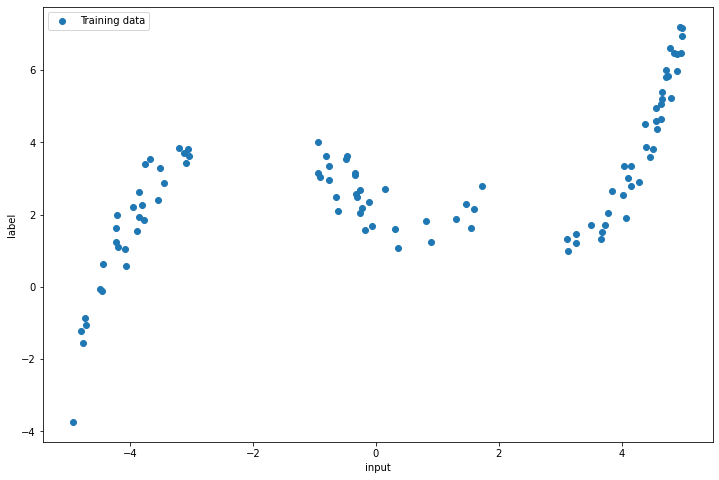

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_data.input, train_data.label, label="Training data")
plt.xlabel('input')
plt.ylabel('label')
plt.legend()

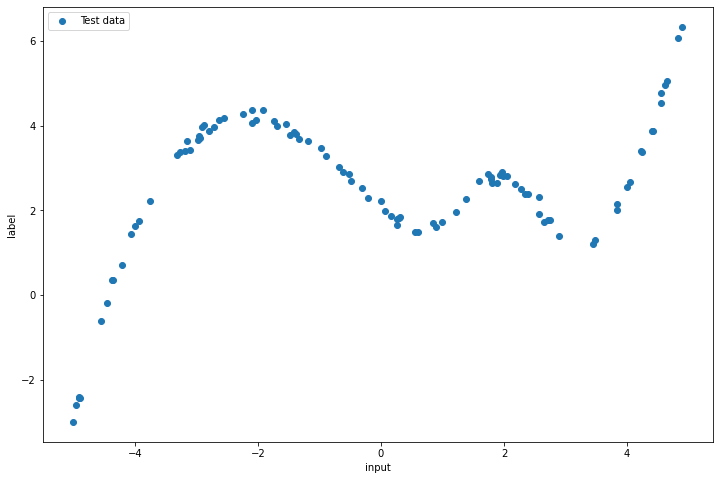

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(test_data.input, test_data.label, label="Test data")
plt.xlabel('input')
plt.ylabel('label')
plt.legend()


In [ ]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        
        self.transform = transform

        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        
        # delete the first row (it contains a string) and the last row (it contains the '\n' character)
        lines.pop(0)
        lines.pop(-1)

        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class ToTensor():
        """Convert sample to Tensors."""
        def __call__(self, sample):
            x, y = sample
            return (torch.tensor([x]).float(), 
                    torch.tensor([y]).float())

In [ ]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

## Network Definition

In [ ]:
class Regressor(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, drop=0.2):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        drop = dropout probability
        """
        super(Regressor,self).__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.drop = nn.Dropout(drop)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.ReLU()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.drop(x)
        x = self.act(self.fc2(x))
        x = self.drop(x)
        x = self.out(x)

        return x

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
Ni = 1
Nh1 = 50
Nh2 = 100
No = 1
drop = 0.02
net = Regressor(Ni, Nh1, Nh2, No, drop)

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# Define loss function
loss_fn = nn.MSELoss()  

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
                                # Check if the GPU is available

net.to(device)

Network initialized


Regressor(
  (fc1): Linear(in_features=1, out_features=50, bias=True)
  (drop): Dropout(p=0.02, inplace=False)
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (act): ReLU()
)

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'net_parameters_before_training.torch')

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])


## Training Loop

In [ ]:
def train_step(net, train_dataloader, optimizer, loss_fn, device):

  train_loss = []
  net.train()

  for sample_batched in train_dataloader:

    # Move data and labels to device
    x_batch = sample_batched[0].to(device) 
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_fn(out, label_batch)

    # Backpropagation
    net.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  return train_loss

In [ ]:
def validation_step(net, valid_dataloader, loss_fn, device):
  
  val_loss= []
  net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
  
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in valid_dataloader:

      # Move data and labels to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

  return val_loss

In [ ]:
def training_loop(net, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs):
 
  train_loss_log = []
  val_loss_log = []

  for num_epoch in tqdm(range(num_epochs)):
    ### TRAIN STEP

    train_loss = train_step(net, train_dataloader, 
                            optimizer, loss_fn, device)
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)


    ### VALIDATION STEP

    val_loss = validation_step(net, valid_dataloader,
                                      loss_fn, device)
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)

  return train_loss_log, val_loss_log


In [ ]:
### TRAINING LOOP
num_epochs = 200
train_loss_log = []
val_loss_log = []

train_loss_log, val_loss_log = training_loop(net, train_dataloader, test_dataloader, optimizer, loss_fn, device, num_epochs)

100%|██████████| 200/200 [00:05<00:00, 37.55it/s]


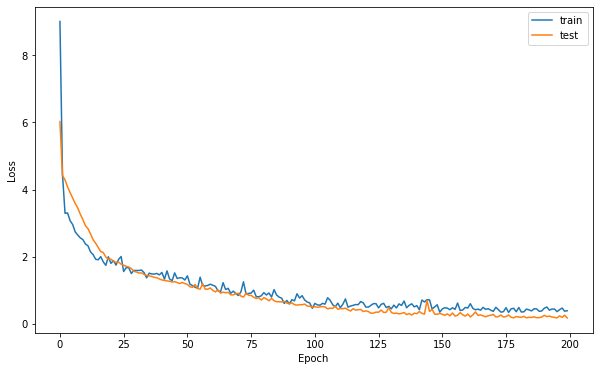

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(train_loss_log, label='train')
plt.plot(val_loss_log, label='test')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.legend()

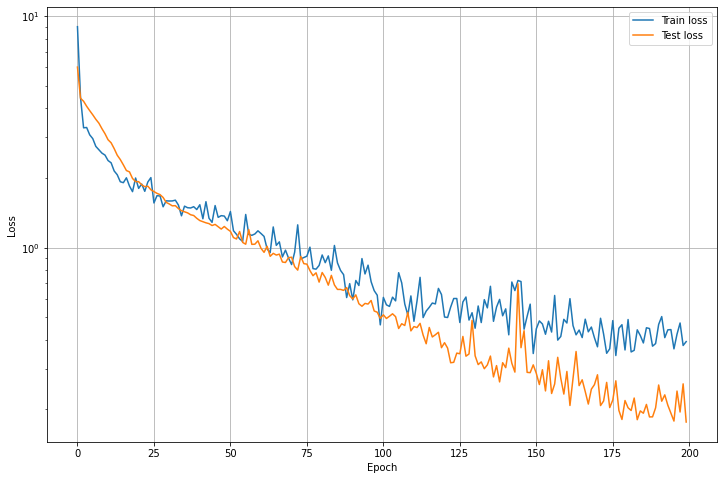

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Network Analysis

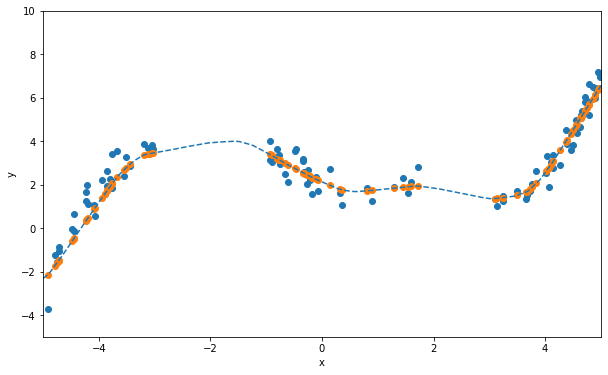

In [ ]:
#Convert data and labels to torch tensors to be given as input to the network

x = torch.unsqueeze(torch.tensor(train_data.input), dim=1).float()
y = torch.unsqueeze(torch.tensor(train_data.label), dim=1).float()

# compute automatically the gradient
x, y = Variable(x), Variable(y)

# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1) #   Adding a dimension to the input space

net.to(device)

# Network output
net.eval()
with torch.no_grad():
    y_vec = net(x_vec)


#Prepare plot of the predicted function

fig, ax = plt.subplots(figsize=(10,6))

plt.cla()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 10)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.scatter(train_data.input, train_data.label, label="Train data")

prediction = net(x.to(device))     # input x and predict based on x

ax.plot(x_vec.squeeze().cpu().numpy(), y_vec.squeeze().cpu().numpy(), "--", label="Network input")

ax.scatter(x.data.cpu().numpy(), prediction.data.cpu().numpy(), label="Network output")

plt.show()


## Hyperparameters tuning

In [ ]:
parameters = {"num_epochs"   : [100, 250, 500],
              "batch_size"   : [4, 10, 16, 32],
              "lr"           : loguniform.rvs(1e-4, 1e-2, size=300),
              "dropout"      : np.random.uniform(0, 0.25, 500),
              "weight_decay" : loguniform.rvs(1e-5, 1e-3, size=300),
              "optimizer"    : ['adam', 'sgd'],  
              "Nh1"          : [20, 50, 100],
              "Nh2"          : [100, 200, 300]
}

In [ ]:
  #function to select randomly the parameters for the random search
def random_params(params):
    selected_params = {}
    for i in params.keys():
        selected_params[i] = np.random.choice(params[i])
    return selected_params

## Implementation of cross-validation using KFold (K=5)

In [ ]:
def random_search(K, grid_params, dataset, n_models, device):
  net_params = []
  train_loss_log = []
  val_loss_log = []

  for i in range(n_models):
    kfold = KFold(K, shuffle=True)
  
    params = random_params(grid_params)
    net_params.append(params)

    train_loss_kfold = np.zeros((K, params['num_epochs']))
    val_loss_kfold = np.zeros((K, params['num_epochs']))

    print('Model ', i+1)
    print('Network parameters:', params)
  
    for fold, (train_index, val_index) in enumerate(kfold.split(dataset)):
      print('FOLD ', fold+1)

      # prepare dataloader

      train_split = SubsetRandomSampler(train_index)
      valid_split = SubsetRandomSampler(val_index)
    
      batch_size = int(params['batch_size'])

      train_dataloader = DataLoader(dataset, batch_size=batch_size,
                                    sampler=train_split)
      valid_dataloader = DataLoader(dataset, batch_size=batch_size,
                                    sampler=valid_split)    
    
      # initialize network
      net = Regressor(1, params['Nh1'], params['Nh2'], 1, params['dropout']).to(device)

      loss_fn = nn.MSELoss()

      #choice of the optimizer
      if params['optimizer']=='adam':
          optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
      elif params['optimizer']=='sgd':
          optimizer = optim.SGD(net.parameters(), lr=params['lr'], momentum=0.9, weight_decay=params['weight_decay'])

      #training loop
      for epoch in range(params['num_epochs']):
        ### TRAIN STEP
        train_loss = train_step(net, train_dataloader, 
                              optimizer, loss_fn, device)
        train_loss = np.mean(train_loss)
      
        ### VALIDATION STEP
        val_loss = validation_step(net, valid_dataloader,
                                        loss_fn, device)
        val_loss = np.mean(val_loss)
    
      # store validation and train losses per fold
      train_loss_kfold[fold, :] = train_loss 
      val_loss_kfold[fold, :] = val_loss 

  # average loss on the k-folds
  train_loss_log.append( np.mean(np.array(train_loss_kfold), axis=0))
  val_loss_log.append( np.mean(np.array(val_loss_kfold), axis=0))

  return net_params, train_loss_log, val_loss_log

In [ ]:
net_params, train_loss_kfold, val_loss_kfold = random_search(5, parameters, train_dataset, 500, device)

Output streaming troncato alle ultime 5000 righe.
FOLD  2
Network initialized
FOLD  3
Network initialized
FOLD  4
Network initialized
FOLD  5
Network initialized
Model  85
Network parameters: {'num_epochs': 500, 'batch_size': 10, 'lr': 0.0031144881164266876, 'dropout': 0.003575322220614463, 'weight_decay': 2.0917729116312905e-05, 'optimizer': 'sgd', 'Nh1': 50, 'Nh2': 300}
FOLD  1
Network initialized
FOLD  2
Network initialized
FOLD  3
Network initialized
FOLD  4
Network initialized
FOLD  5
Network initialized
Model  86
Network parameters: {'num_epochs': 250, 'batch_size': 10, 'lr': 0.0025510186289917952, 'dropout': 0.027460494426852777, 'weight_decay': 5.599020248425305e-05, 'optimizer': 'sgd', 'Nh1': 20, 'Nh2': 200}
FOLD  1
Network initialized
FOLD  2
Network initialized
FOLD  3
Network initialized
FOLD  4
Network initialized
FOLD  5
Network initialized
Model  87
Network parameters: {'num_epochs': 250, 'batch_size': 16, 'lr': 0.0006625509966779856, 'dropout': 0.14368502420646012, 'wei

In [ ]:
avg_val_loss = [np.mean(vl) for vl in val_loss_log]
print('Minimum average validation losses (top 10):', np.sort(avg_val_loss)[:10])

best_params = net_params[np.argmin(avg_val_loss)]
print('Best network parameters:', best_params)

# store best parameters
#net_state_dict = best_params.state_dict()
#torch.save(net_state_dict, 'best_net_parameters_reg.torch')
# save the optimizer state
#torch.save(optimizer.state_dict(), 'optimizer_state_reg.torch')

Minimum average validation losses (top 10): [0.17638849 0.17808552 0.18054737 0.18094684 0.18558899 0.18573104
 0.19248492 0.19255655 0.19488683 0.19702247]
Best network parameters: {'num_epochs': 250, 'batch_size': 4, 'lr': 0.00035030760804731725, 'dropout': 0.16386430383573014, 'weight_decay': 0.0002568967853475773, 'optimizer': 'sgd', 'Nh1': 100, 'Nh2': 100}


## Final accuracy with the best model

In [ ]:
batch_size = int(best_params['batch_size'])

# train dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

#test dataloader
val_dataloader  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

In [ ]:
net = Regressor(1, best_params['Nh1'], best_params['Nh2'], 1, best_params['dropout']).to(device)

if best_params['optimizer']=='sgd':
    optimizer = optim.SGD(net.parameters(), lr=best_params['lr'], momentum=0.9, weight_decay=best_params['weight_decay'])
elif best_params['optimizer']=='adam':
    optimizer = optim.Adam(net.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

best_train_loss, best_val_loss = training_loop(net, train_dataloader, val_dataloader, optimizer, loss_fn, device, best_params['num_epochs'])

Network initialized


100%|██████████| 250/250 [00:13<00:00, 18.42it/s]


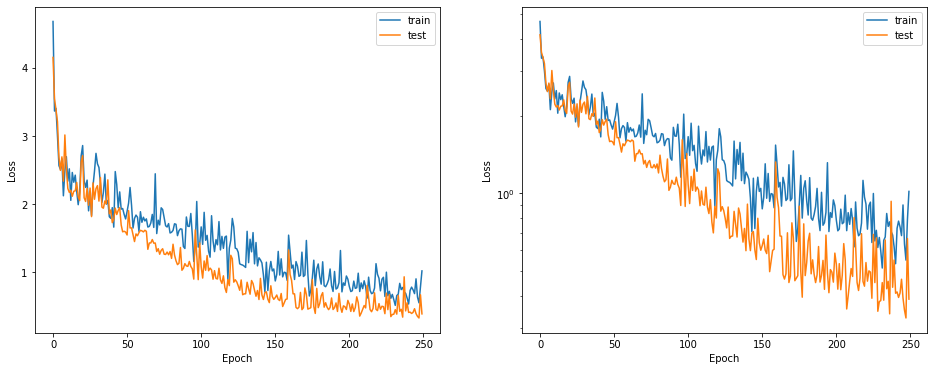

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')


ax[0].plot(best_train_loss, label='train')
ax[0].plot(best_val_loss, label='test')

ax[1].semilogy(best_train_loss, label='train')
ax[1].semilogy(best_val_loss, label='test')
ax[0].legend()
ax[1].legend()


In [ ]:
print(train_loss_log[-1], val_loss_log[-1])

0.39257842 0.17638849


In [ ]:
#Test final accuracy

accuracy = [] #initialize vector containing accuracies
net.eval()   #set evaluation mode
    
with torch.no_grad():                         
  for sample_batched in tqdm(test_dataloader):
              
    x_batch = sample_batched[0].to(device)       
    label_batch = sample_batched[1].to(device)       

    out = net(x_batch)       #forward pass
                
    batch_loss = loss_fn(out, label_batch) #compute batch loss, save it
    test_loss = batch_loss.detach().cpu().numpy()
                
    accuracy.append(test_loss.mean())       #store batch accuracy
        
final_test_loss = np.array(accuracy).mean()
        
print(final_test_loss)

100%|██████████| 1/1 [00:00<00:00, 205.78it/s]

0.38715667


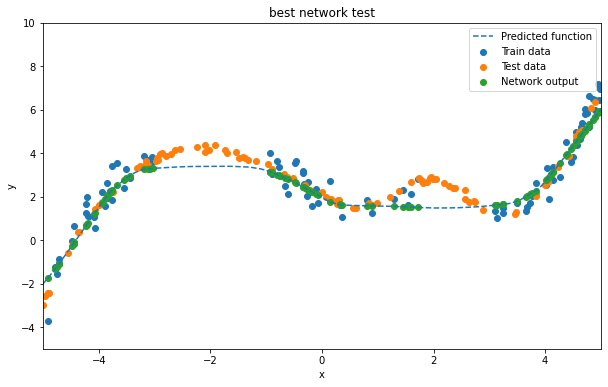

In [ ]:
#Convert data and labels to torch tensors to be given as input to the network

#x = torch.unsqueeze(torch.tensor(train_data.input), dim=1).float()
#y = torch.unsqueeze(torch.tensor(train_data.label), dim=1).float()

# compute automatically the gradient
#x, y = Variable(x), Variable(y)

# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1) #   Adding a dimension to the input space

net.to(device)

# Network output
net.eval()
with torch.no_grad():
    y_vec = net(x_vec)


#Prepare plot of the predicted function

fig, ax = plt.subplots(figsize=(10,6))

plt.cla()
ax.set_title("best network test")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 10)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.scatter(train_data.input, train_data.label, label="Train data")
ax.scatter(test_data.input, test_data.label, label="Test data")


prediction = net(x.to(device))     # input x and prediction based on x

ax.plot(x_vec.squeeze().cpu().numpy(), y_vec.squeeze().cpu().numpy(), "--", label="Predicted function")

ax.scatter(x.data.cpu().numpy(), prediction.data.cpu().numpy(), label="Network output")
plt.legend()
plt.show()

## Weight analysis

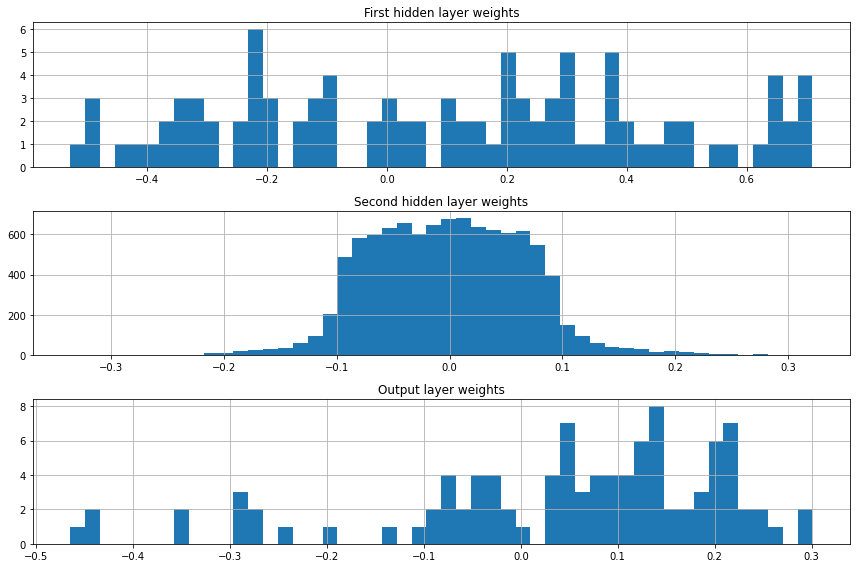

In [ ]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

## Activation Analysis

In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

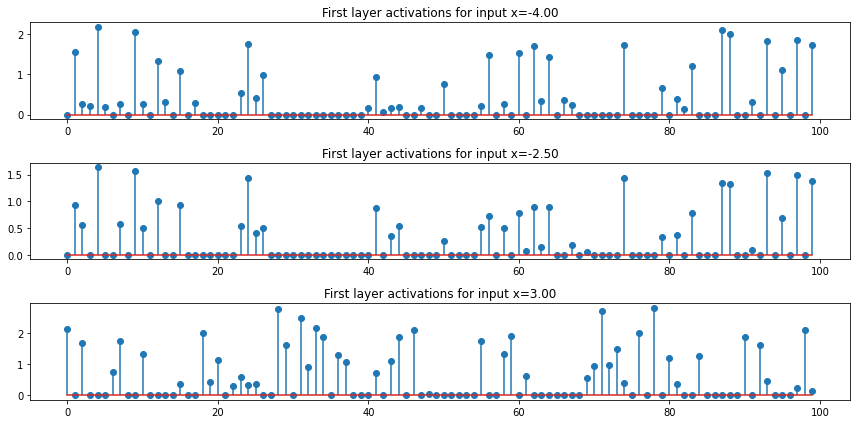

In [ ]:
### Register hook  
hook_handle = net.fc1.register_forward_hook(get_activation)

### Analyze activations
net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-4]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([-2.5]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([3]).float().to(device)
    y3 = net(x3)
    z3 = activation
  

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('First layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('First layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('First layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

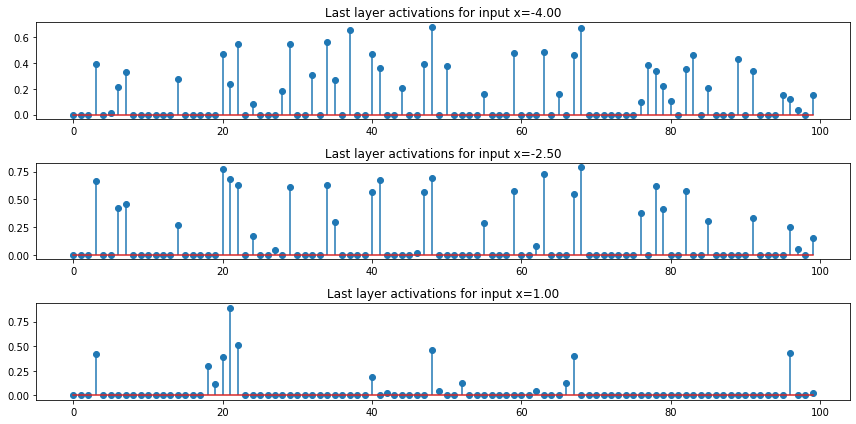

In [ ]:
### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-4]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([-2.5]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([1]).float().to(device)
    y3 = net(x3)
    z3 = activation
  

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

# Classification task

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
import os

! pip install pytorch-lightning
! pip install optuna

import pytorch_lightning as pl
import optuna

     |████████████████████████████████| 526 kB 5.4 MB/s 
     |████████████████████████████████| 829 kB 42.8 MB/s 
     |████████████████████████████████| 332 kB 43.0 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 132 kB 47.7 MB/s 
     |████████████████████████████████| 1.1 MB 35.7 MB/s 
     |████████████████████████████████| 160 kB 46.9 MB/s 
     |████████████████████████████████| 271 kB 52.1 MB/s 
     |████████████████████████████████| 192 kB 49.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=1328139043faafbb423679168222560b913102c04ad75efb42eb0e9912bf2ad1
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

### Dataset

In [ ]:
train_dataset = datasets.FashionMNIST('classifier_data', train=True, download=True)

test_dataset  = datasets.FashionMNIST('classifier_data', train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



In [ ]:
print(train_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: classifier_data
    Split: Train


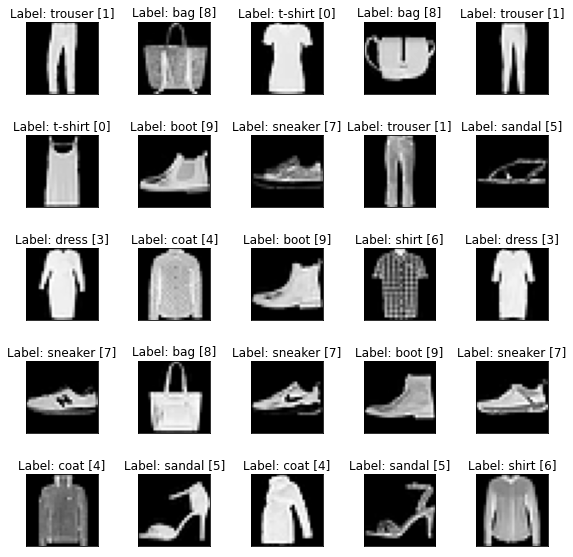

In [ ]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5),)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5),)
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [ ]:
train_split, val_split = torch.utils.data.random_split(train_dataset, [50000, 10000])

In [ ]:
### Define train dataloader
train_dataloader = DataLoader(train_split, shuffle=True, batch_size=64, num_workers=0)

### Define validation dataloader
val_dataloader = DataLoader(val_split, batch_size=64, shuffle=False, num_workers=0)

### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0)

In [ ]:
dataiter = iter(train_dataloader)
print(dataiter)
images, labels =  dataiter.next()

## Network Definition

In [ ]:
class Basic_Classifier(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, Nh3, No, drop=0.2):
        
        super(Basic_Classifier, self).__init__()
        
        print('Network initialized')

        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        self.dropout = nn.Dropout(drop)

    def forward(self, x, additional_out=False):
        x = x.view(x.shape[0], -1)
        #print(x.size())
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.out(x), dim=1)
        return x


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cpu


In [ ]:
# Initialize the network
torch.manual_seed(0)
Ni = 784
Nh1 = 256
Nh2 = 128
Nh3 = 64
No = 10

In [ ]:
net = Basic_Classifier(Ni, Nh1, Nh2, Nh3, No)
net.to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

Network initialized


## Training Loop

In [ ]:
def train_step(net, train_dataloader, optimizer, loss_fn, device):

  train_loss = []
  net.train()

  for sample_batched in train_dataloader:

    # Move data and labels to device
    x_batch = sample_batched[0].to(device) 
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_fn(out, label_batch)

    # Backpropagation
    net.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  return train_loss

In [ ]:
def validation_step(net, valid_dataloader, loss_fn, device):
  
  val_loss= []
  net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
  
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in valid_dataloader:

      # Move data and labels to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

  return val_loss

In [ ]:
def training_loop(net, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs):
 
  train_loss_log = []
  val_loss_log = []

  for num_epoch in tqdm(range(num_epochs)):
    ### TRAIN STEP

    train_loss = train_step(net, train_dataloader, 
                            optimizer, loss_fn, device)
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    #if epoch_num%10==0: 
      #print(f"AVERAGE TRAIN LOSS: {train_loss}")


    ### VALIDATION STEP

    val_loss = validation_step(net, valid_dataloader,
                                      loss_fn, device)
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)

  return train_loss_log, val_loss_log


In [ ]:
num_epochs = 20
train_loss_log = []
val_loss_log = []

train_loss_log, val_loss_log = training_loop(net, train_dataloader, test_dataloader, optimizer,
                                             loss_fn, device, num_epochs)

100%|██████████| 20/20 [05:01<00:00, 15.07s/it]


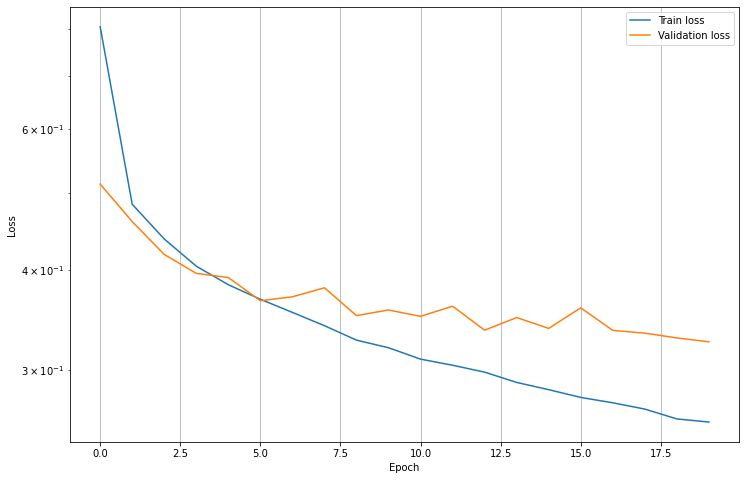

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]


In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        
        outputs = net(x_batch)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == label_batch).squeeze()
        #print(label_batch.shape)
        for i in range(label_batch.shape[0]):
            label = label_batch[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))


Accuracy of T-shirt/Top: 88.20%
Accuracy of Trouser: 96.90%
Accuracy of Pullover: 86.10%
Accuracy of Dress: 90.00%
Accuracy of Coat: 78.70%
Accuracy of Sandal: 95.80%
Accuracy of Shirt: 64.70%
Accuracy of Sneaker: 95.20%
Accuracy of Bag: 97.80%
Accuracy of Ankle Boot: 94.80%


In [ ]:
sum = 0
for i in range(10):
    sum += (class_correct[i] * 100 / total_correct[i])

sum/=10
print(sum)

88.82000000000001


## CNN Network Definition

In [ ]:
class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [ ]:
netCNN = CNNClassifier()
netCNN.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(netCNN.parameters(), lr=1e-3)

## Training Loop

In [ ]:
num_epochs = 20
train_loss_log = []
val_loss_log = []

train_loss_log, val_loss_log = training_loop(netCNN, train_dataloader, test_dataloader, optimizer,
                                             loss_fn, device, num_epochs)

100%|██████████| 20/20 [28:55<00:00, 86.78s/it]


In [ ]:
torch.save(netCNN.state_dict(), 'netCNN_params.pth')

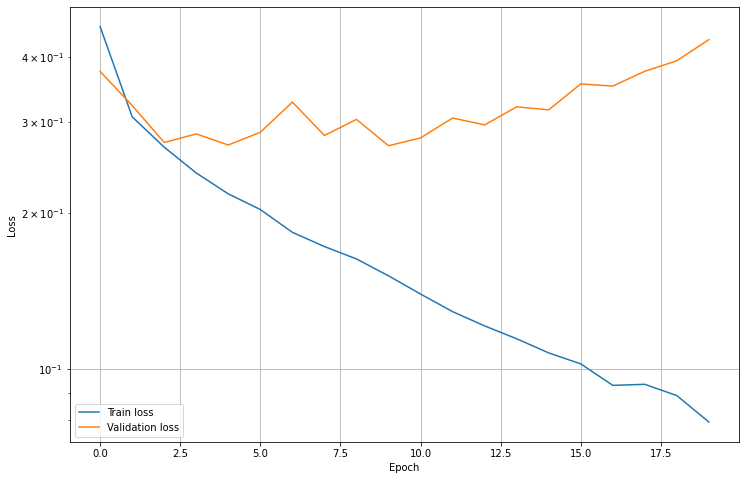

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        
        outputs = netCNN(x_batch)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == label_batch).squeeze()
        #print(label_batch.shape)
        for i in range(label_batch.shape[0]):
            label = label_batch[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))


Accuracy of T-shirt/Top: 82.70%
Accuracy of Trouser: 98.80%
Accuracy of Pullover: 87.90%
Accuracy of Dress: 88.10%
Accuracy of Coat: 89.00%
Accuracy of Sandal: 99.40%
Accuracy of Shirt: 70.00%
Accuracy of Sneaker: 94.70%
Accuracy of Bag: 96.50%
Accuracy of Ankle Boot: 95.80%


In [ ]:
sum = 0
for i in range(10):
    sum += (class_correct[i] * 100 / total_correct[i])

sum/=10
print(sum)

90.28999999999999


## Activation analysis

In [ ]:
netCNN.load_state_dict(torch.load('netCNN_params.pth'))

In [ ]:
## Extract weights 
# Layer 1 weights
weights_l1 = netCNN.layer1[0].weight.data.cpu().numpy()
# Layer 2 weights
weights_l2 = netCNN.layer2[0].weight.data.cpu().numpy()

print(weights_l2.shape)

(64, 32, 3, 3)


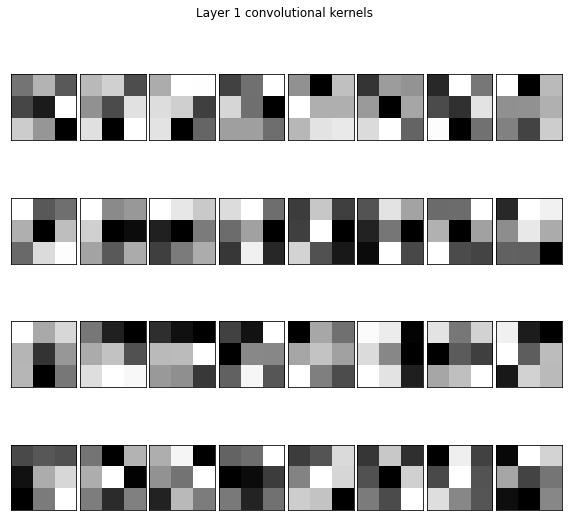

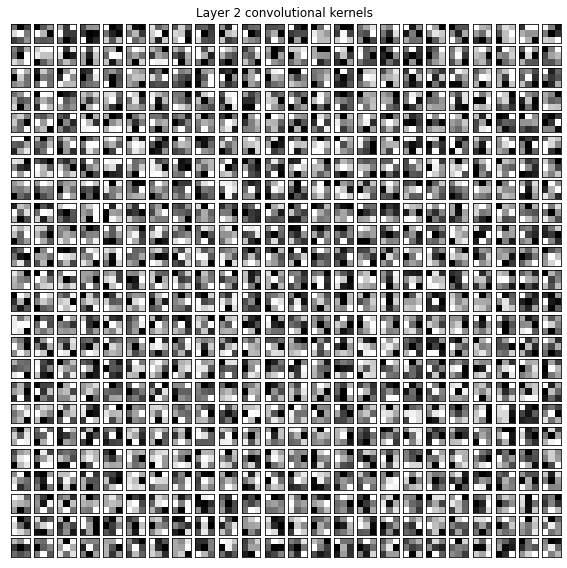

In [ ]:
### Plot the weights (this is a utility function, no need to analyze this code)
def plot_nchw_data(data, h_num, v_num, title):
    fig, axs = plt.subplots(h_num, v_num, figsize=(8,8))
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()

plot_nchw_data(weights_l1, 4, 8, 'Layer 1 convolutional kernels')
plot_nchw_data(weights_l2, 24, 24, 'Layer 2 convolutional kernels')


In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

In [ ]:
image = DataLoader(test_dataset, batch_size=1, shuffle=False) 

### Register hook  
hook_handle = netCNN.layer1.register_forward_hook(get_activation)

### Analyze activations
net = netCNN.to(device)
net.eval()

with torch.no_grad():
    for s_batch in image:
        # Move data to device
        x1 = s_batch[0].to(device)
        # Forward pass
        y1 = netCNN(x1)
        z1 = activation

### Remove hook
hook_handle.remove()

act1 = z1.cpu().numpy()

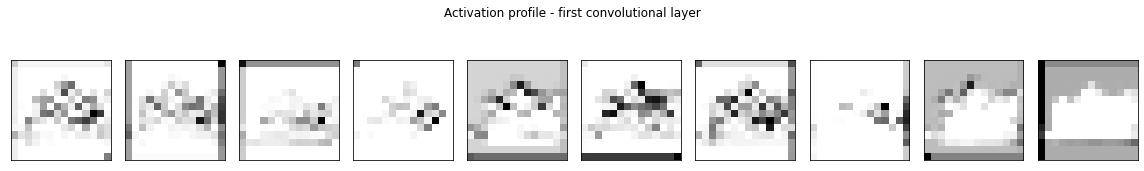

In [ ]:
## Plot activations
fig, ax = plt.subplots(1, 10, figsize=(16,3))
for i in range(10):
    ax[i].imshow( act1[0, i, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('Activation profile - first convolutional layer')    
plt.tight_layout()

plt.show()  

In [ ]:
image = DataLoader(test_dataset, batch_size=1, shuffle=False) 

### Register hook  
hook_handle = netCNN.layer2.register_forward_hook(get_activation)

### Analyze activations
net = netCNN.to(device)
net.eval()

with torch.no_grad():
    for s_batch in image:
        # Move data to device
        x1 = s_batch[0].to(device)
        # Forward pass
        y1 = netCNN(x1)
        z1 = activation

### Remove hook
hook_handle.remove()

act1 = z1.cpu().numpy()

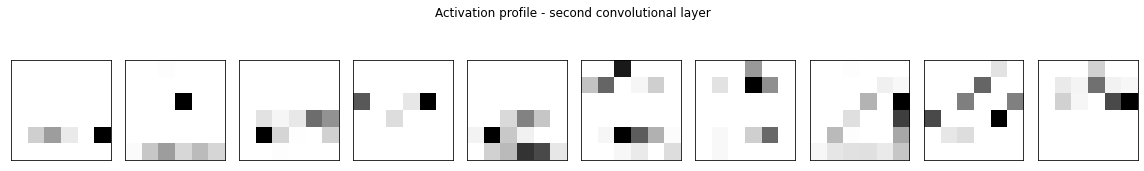

In [ ]:
## Plot activations
fig, ax = plt.subplots(1, 10, figsize=(16,3))
for i in range(10):
    ax[i].imshow( act1[0, i, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('Activation profile - second convolutional layer')    
plt.tight_layout()

plt.show()  

## Hyperparameter tuning with Pytorch-Lightning and Optuna

## Network Definition

In [ ]:
# Define a LightningModule (nn.Module subclass)
# A LightningModule defines a full system (ie: a GAN, autoencoder, BERT or a simple Image Classifier).

class LitNet(pl.LightningModule):
    
    def __init__(self, trial):
       
        super().__init__()
        
        self.classifier = nn.Sequential(
                                        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                        #nn.BatchNorm2d(32),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2, stride=2),
        
                                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                        #nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2),
                                            
                                        nn.Flatten(start_dim=1),
                                        nn.Linear(in_features=64*6*6, out_features=100),
                                        nn.Dropout2d(0.2),
                                        nn.Linear(in_features=100, out_features=50),
                                        nn.Linear(in_features=50, out_features=10)
                                        )

        print('Network initialized')
                      
        self.trial = trial

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        #x = x.view(x.shape[0], -1)
        out = self.classifier(x)
        return out
            
    # Training_step defines the training loop. 
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.classifier(x_batch)
        train_loss = F.cross_entropy(out, label_batch)
        self.log("train_loss", train_loss.item())
        return train_loss

    def validation_step(self, batch, batch_idx=None, loss_name='valid_loss'):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.classifier(x_batch)
        val_loss = F.cross_entropy(out, label_batch)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss

    def configure_optimizers(self):
        lr  = self.trial.suggest_loguniform('learning_rate', 1e-5, 5e-3)
        opt = self.trial.suggest_categorical('optimizer', ['sgd', 'Adam'])
        wd  = self.trial.suggest_loguniform('weight_decay', 1e-6, 1e-4)
        mom = self.trial.suggest_uniform('momentum', 0.6, 1.)
        if opt=='sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=mom, weight_decay=wd)
        elif opt=='Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)

        return optimizer

## Setting Up Callback Functions and Dataloaders

In [ ]:
class MetricsCallback(pl.Callback):
    '''
    To return losses and other metrics logged during training and validation.
    '''

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)

In [ ]:
train_dataset = datasets.FashionMNIST('classifier_data', train=True, download=True)

test_dataset  = datasets.FashionMNIST('classifier_data', train=False, download=True)

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5),)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5),)
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [ ]:
# prepare validation set by splitting the train one
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# set up dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
def objective(trial):
    # Function to optimize from optuna
    metrics_callback = MetricsCallback()
    
    trainer = pl.Trainer( logger=False,
                          max_epochs=20,
                          gpus=-1 if torch.cuda.is_available() else None,
                          callbacks=[ metrics_callback, 
                                    optuna.integration.PyTorchLightningPruningCallback(trial, monitor="valid_loss"),
                                    pl.callbacks.progress.TQDMProgressBar(refresh_rate=20)])
                         

    model = LitNet(trial)
    trainer.fit(model, train_dataloader, val_dataloader)

    return metrics_callback.metrics[-1]["valid_loss"].item()

## Optimization with Optuna

In [ ]:
pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
    
study = optuna.create_study(direction="minimize", pruner=pruner)

#study.enqueue_trial({'optimizer': 'Adam', 'learning_rate': 1e-3, 'weight_decay': 1e-5, 'momentum': 0.9})# select starting point

study.optimize(objective, n_trials=5, timeout=None)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-01-02 08:04:32,905] A new study created in memory with name: no-name-b31d84df-ddda-43c8-b9ed-fdb5b26e59f5
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 254 K 
------------------------------------------
254 K     Trainable params
0         Non-trainable params
254 K     Total params
1.020     Total estimated model params size (MB)


Network initialized


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.



Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-02 08:24:54,472] Trial 0 finished with value: 2.164984941482544 and parameters: {'learning_rate': 8.752726721785302e-05, 'optimizer': 'sgd', 'weight_decay': 5.276548261242779e-05, 'momentum': 0.6841827446723144}. Best is trial 0 with value: 2.164984941482544.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 254 K 
------------------------------------------
254 K     Trainable params
0         Non-trainable params
254 K     Total params
1.020     Total estimated model params size (MB)


Network initialized


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning:

Checkpoint directory /content/checkpoints exists and is not empty.



Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.



Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-02 08:45:21,144] Trial 1 finished with value: 0.8158907294273376 and parameters: {'learning_rate': 4.4321284211166515e-05, 'optimizer': 'sgd', 'weight_decay': 8.672363570431309e-05, 'momentum': 0.9464523296692645}. Best is trial 1 with value: 0.8158907294273376.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 254 K 
------------------------------------------
254 K     Trainable params
0         Non-trainable params
254 K     Total params
1.020     Total estimated model params size (MB)


Network initialized


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning:

Checkpoint directory /content/checkpoints exists and is not empty.



Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.



Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-02 09:17:05,127] Trial 2 finished with value: 0.14978186786174774 and parameters: {'learning_rate': 0.004007026808018473, 'optimizer': 'Adam', 'weight_decay': 4.3327734192773594e-05, 'momentum': 0.6037422141294034}. Best is trial 2 with value: 0.14978186786174774.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 254 K 
------------------------------------------
254 K     Trainable params
0         Non-trainable params
254 K     Total params
1.020     Total estimated model params size (MB)


Network initialized


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning:

Checkpoint directory /content/checkpoints exists and is not empty.



Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.



Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-02 09:37:57,464] Trial 3 finished with value: 0.4238804280757904 and parameters: {'learning_rate': 0.001941712105867948, 'optimizer': 'sgd', 'weight_decay': 8.4650430836376e-06, 'momentum': 0.7311440961202027}. Best is trial 2 with value: 0.14978186786174774.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 254 K 
------------------------------------------
254 K     Trainable params
0         Non-trainable params
254 K     Total params
1.020     Total estimated model params size (MB)


Network initialized


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning:

Checkpoint directory /content/checkpoints exists and is not empty.



Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.



Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-01-02 09:58:44,481] Trial 4 finished with value: 0.3912700116634369 and parameters: {'learning_rate': 2.518020455039569e-05, 'optimizer': 'Adam', 'weight_decay': 1.1851106011090753e-06, 'momentum': 0.9102314666625391}. Best is trial 2 with value: 0.14978186786174774.


Number of finished trials: 5
Best trial:
  Value: 0.14978186786174774
  Params: 
    learning_rate: 0.004007026808018473
    optimizer: Adam
    weight_decay: 4.3327734192773594e-05
    momentum: 0.6037422141294034


In [ ]:
optuna.visualization.plot_optimization_history(study, target_name='Validation loss')

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
best_trial = study.best_trial
best_params = best_trial.params

print('Best trial:')
print('Value: ', best_trial.value)

print('Best network parameters: ')
for key, value in best_params.items():
    print(f'    {key}: {value}')

Best trial:
Value:  0.14978186786174774
Best network parameters: 
    learning_rate: 0.004007026808018473
    optimizer: Adam
    weight_decay: 4.3327734192773594e-05
    momentum: 0.6037422141294034


## Network with best parameters

In [ ]:
class LitNet(pl.LightningModule):
    
    def __init__(self, params):
       
        super().__init__()
        
        self.classifier = nn.Sequential(
                                        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                        #nn.BatchNorm2d(32),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2, stride=2),
        
                                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                        #nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2),
                                            
                                        nn.Flatten(start_dim=1),
                                        nn.Linear(in_features=64*6*6, out_features=100),
                                        nn.Dropout2d(0.2),
                                        nn.Linear(in_features=100, out_features=50),
                                        nn.Linear(in_features=50, out_features=10)
                                        )

        print('Network initialized')
                      
        self.params = params

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        #x = x.view(x.shape[0], -1)
        out = self.classifier(x)
        return out
            
    # Training_step defines the training loop. 
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.classifier(x_batch)
        train_loss = F.cross_entropy(out, label_batch)
        self.log("train_loss", train_loss.item())
        return train_loss

    def validation_step(self, batch, batch_idx=None, loss_name='valid_loss'):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.classifier(x_batch)
        val_loss = F.cross_entropy(out, label_batch)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
      
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        lr  = self.params['learning_rate']
        opt = self.params['optimizer']
        wd  = self.params['weight_decay']
        mom = self.params['momentum']
        if opt=='sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=mom, weight_decay=wd)
        elif opt=='Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)

        return optimizer

In [ ]:
best_net = LitNet(best_params)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
best_net.to(device)

trainer = pl.Trainer(gpus=0, max_epochs=100, 
                     callbacks=[pl.callbacks.EarlyStopping(monitor='valid_loss'),
                                pl.callbacks.progress.TQDMProgressBar(refresh_rate=50)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Network initialized
Selected device: cpu


In [ ]:
trainer.fit(best_net, train_dataloader, val_dataloader)


  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 254 K 
------------------------------------------
254 K     Trainable params
0         Non-trainable params
254 K     Total params
1.020     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
trainer.test(best_net, test_dataloader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3612912595272064}
--------------------------------------------------------------------------------


[{'test_loss': 0.3612912595272064}]